In [14]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, Conv2D
from tensorflow.keras.callbacks import EarlyStopping


In [16]:

df = pd.read_csv(r'C:\Users\Pranav Desai\Desktop\Chronic Disease\Augmented kidney_dataset.csv')

In [17]:
x = df.drop("classification", axis=1).values
y = df["classification"].values



In [18]:
# Normalize features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [19]:

# Reshape to (samples, height, width, channels) to simulate image input
X_reshaped = x_scaled.reshape(x_scaled.shape[0], x_scaled.shape[1], 1, 1)

In [20]:
feature_count = x_scaled.shape[1]
image_size = int(np.ceil(np.sqrt(feature_count)))  # Create square input
padded_features = np.zeros((x_scaled.shape[0], image_size**2))
padded_features[:, :feature_count] = x_scaled
x_image = padded_features.reshape(-1, image_size, image_size, 1)

In [21]:
def preprocess_images(x_image):
    # Convert to RGB and resize on CPU
    x_image = tf.cast(x_image, tf.float32)
    x_rgb = tf.concat([x_image] * 3, axis=-1)
    x_resized = tf.image.resize(x_rgb, [224, 224])
    return x_resized

with tf.device('/CPU:0'):
    x_resized = preprocess_images(x_image)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_resized.numpy(), y, test_size=0.2, random_state=42)

In [24]:

# Clear memory
tf.keras.backend.clear_session()

# Use CPU to avoid GPU overload
with tf.device('/CPU:0'):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False

In [29]:
# Clear previous models and memory
import gc
from tensorflow.keras import backend as K
K.clear_session()
gc.collect()

with tf.device('/CPU:0'):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)   # Output shape: (None, 1280)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)  # for binary classification

    model = Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [32]:
history = model.fit(x_train, y_train,validation_split=0.2,epochs=30, batch_size=32,callbacks=[early_stop],verbose=1)

Epoch 1/30
200/200 [==============================] - 15s 56ms/step - loss: 0.0716 - accuracy: 0.9786 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 2/30
200/200 [==============================] - 10s 51ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 3/30
200/200 [==============================] - 10s 51ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/30
200/200 [==============================] - 10s 51ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/30
200/200 [==============================] - 10s 50ms/step - loss: 8.2497e-04 - accuracy: 1.0000 - val_loss: 7.9095e-04 - val_accuracy: 1.0000
Epoch 6/30
200/200 [==============================] - 10s 51ms/step - loss: 5.5868e-04 - accuracy: 1.0000 - val_loss: 5.4565e-04 - val_accuracy: 1.0000
Epoch 7/30
200/200 [==============================] - 10s 50ms/step - loss: 3.9221e-04 - accuracy: 1.0000 - val_loss: 3.

In [33]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1225
           1       1.00      1.00      1.00       775

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [38]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

63/63 [==============================] - 3s 40ms/step - loss: 5.2941e-06 - accuracy: 1.0000
Test Accuracy: 1.00


In [39]:
# Extract values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


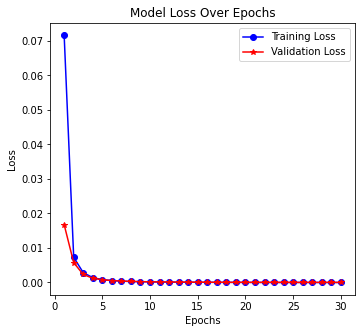

In [40]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

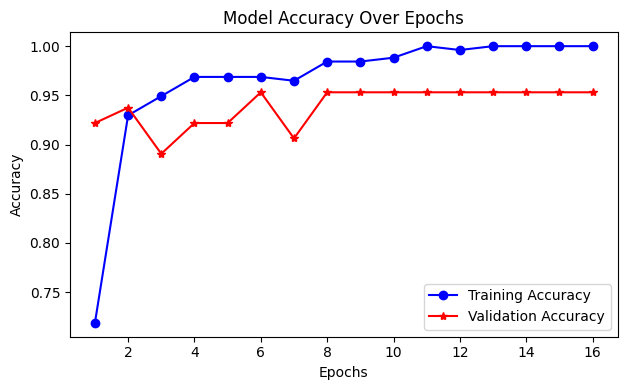

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results
evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


d:\Python\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


{'total_parameters': 2340033,
 'FLOPs': 599215297,
 'GFLOPs': 0.599215297,
 'model_size_bytes': 10507680,
 'model_size_MB': 10.020904541015625,
 'inference_time_seconds': 3.1899490356445312,
 'accuracy': 1.0}